Explore Coha data

Date: 20181202
    
Author: bpeloqui

Summary
-------

Analyse diachronic measures of entropy.

Hamilton et al. (2016) binned by decade so doing that here...

In [143]:
from collections import defaultdict, Counter
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import tqdm

Load and preprocess data

In [144]:
dir_path = '../data/COHA_SAMPLE/wordLemPos/'

In [149]:
def get_date(f_path):
    return re.findall('_([12]\d{3})_', f_path)[0]

def date2decade(year):
    year = int(year)
    return year - (year % 10)
    

def get_genre(f_path):
    return re.findall('([a-z]+)?_[12]', f_path)[0]

def get_words_from_doc(f_path):
    """Parse a words file from sample of https://corpus.byu.edu/coha/ data.
    
    Returns
    -------
    tuple of str, str, list
        Date, Doc ID, words 
        
    """
    words = []
    with open(f_path) as f:
        for i, line in enumerate(f):
            elements = line.split('\t')
            if i == 0:
                doc_num = elements[0]
            elif i < 5:
                continue
            else:
                words.append(elements[1])
    return get_date(f_path), get_genre(f_path), doc_num, words
    
def process_all_sample_docs(dir_path):
    data = defaultdict()
    for f in tqdm.tqdm(os.listdir(dir_path)):
        date, genre, doc, words = get_words_from_doc(os.path.join(dir_path, f))
        decade = date2decade(date)
        data[(decade, doc)] = (genre, words)
    return data

In [150]:
d = process_all_sample_docs(dir_path)



  0%|          | 0/1144 [00:00<?, ?it/s]

  0%|          | 5/1144 [00:00<00:54, 20.95it/s]

  2%|▏         | 20/1144 [00:00<00:22, 50.14it/s]

  5%|▍         | 54/1144 [00:00<00:10, 107.88it/s]

  6%|▌         | 69/1144 [00:00<00:09, 113.71it/s]

 10%|▉         | 113/1144 [00:00<00:06, 159.71it/s]

 12%|█▏        | 136/1144 [00:00<00:06, 144.13it/s]

 14%|█▎        | 155/1144 [00:01<00:06, 147.47it/s]

 17%|█▋        | 193/1144 [00:01<00:05, 167.08it/s]

 21%|██        | 235/1144 [00:01<00:04, 186.05it/s]

 24%|██▍       | 273/1144 [00:01<00:04, 200.26it/s]

 29%|██▊       | 327/1144 [00:01<00:03, 223.43it/s]

 32%|███▏      | 365/1144 [00:01<00:03, 227.37it/s]

 36%|███▋      | 416/1144 [00:01<00:03, 232.67it/s]

 40%|███▉      | 452/1144 [00:01<00:02, 237.58it/s]

 42%|████▏     | 485/1144 [00:02<00:02, 239.83it/s]

 45%|████▌     | 517/1144 [00:02<00:02, 237.82it/s]

 48%|████▊     | 546/1144 [00:02<00:02, 230.47it/s]

 51%|█████     | 586/1144 [00:02<00:02, 233.37it/s]

 54%|████

In [151]:
def create_unigrams(words):
    counts = Counter(words)
    total = np.sum(counts.values())
    normed_counts = defaultdict()
    return normed_counts 

def calc_unigram_entropy(probs):
    return -np.sum([pr * np.log(pr) for pr in probs])

Diachronic entropy measures

In [152]:
d_counts = defaultdict(Counter)
# Marginalize over doc_ids
for (date, doc_id), (genre, words) in d.items():
    counts = Counter(words)
    d_counts[(date, genre)] += counts

In [153]:
df = []
for (date, genre), counts in d_counts.items():
    total = np.sum(counts.values())
    prs = [float(v) / total for v in counts.values()]
    entropy = calc_unigram_entropy(prs)
    df.append({
        "date": date,
        "genre": genre,
        "ent": entropy
    })
df = pd.DataFrame(df)

In [154]:
df['date'] = pd.to_numeric(df['date'])

Genre:	news;	blue
Genre:	nf;	red
Genre:	mag;	green
Genre:	fic;	purple


Text(0.5,0,'Year')

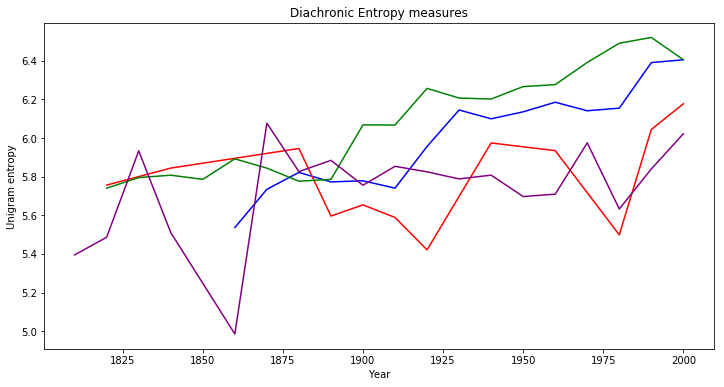

In [159]:
plt.figure(figsize=(12, 6))
genres = set(df['genre'])
genre_colors = ['blue', 'red', 'green', 'purple']

for i, genre in enumerate(genres):
    print("Genre:\t{};\t{}".format(genre, genre_colors[i]))
    curr_df = df[df['genre'] == genre] \
        .sort_values(by=['date'])
    plt.plot(curr_df['date'], curr_df['ent'], color=genre_colors[i])
plt.title("Diachronic Entropy measures")
plt.ylabel("Unigram entropy")
plt.xlabel("Year")

Cross entropy measures

In [191]:
def calc_cross_entroy(prs1, prs2):
    return -np.sum([pr1 * np.log(pr2) for pr1, pr2 in zip(prs1, prs2)])

def cross_entropy(counts1, counts2):
    # First add smoothing with shared dict
    all_words = set(counts1.keys()) | set(counts2.keys())
    d_pairs = defaultdict(list)
    total1 = 0
    total2 = 0
    # Get total
    for word in all_words:
        cnt1 = counts1[word] + 1
        cnt2 = counts2[word] + 1
        d_pairs[word] = [cnt1, cnt2]
        total1 += cnt1
        total2 += cnt2
    # Normalize for probs
    prs1 = []
    prs2 = []
    for word in all_words:
        cnt1 = d_pairs[word][0]
        pr1 = float(cnt1) / total1
        cnt2 = d_pairs[word][1]
        pr2 = float(cnt2) / total2
        prs1.append(pr1)
        prs2.append(pr2)
    return calc_cross_entroy(prs1, prs2)
print(cross_entropy(d_counts[(1920, 'mag')], d_counts[(1920, 'nf')]))
print(cross_entropy(d_counts[(1920, 'nf')], d_counts[(1920, 'nf')]))

7.22323512852901
5.630273400073477


TypeError: ufunc 'log' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [196]:
import itertools as it
all_pairs = it.product(genres, repeat=2)

In [205]:
decades = set(dec for dec, genre in d_counts.keys())

In [209]:
d_ces = []
for decade in tqdm.tqdm(decades):
    df_curr = df[df['date']==decade]
    genre_pairs = it.product(set(df_curr['genre']), repeat=2)
    for g1, g2 in genre_pairs:
        pair = '-'.join([g1, g2])
        ce = cross_entropy(d_counts[(decade, g1)], d_counts[(decade, g2)])
        d_ces.append({
            "pair": pair,
            "decade": decade,
            "ce": ce
        })
df_ce = pd.DataFrame(d_ces)



  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:00<00:14,  1.27it/s]

 10%|█         | 2/20 [00:01<00:16,  1.07it/s]

 15%|█▌        | 3/20 [00:02<00:14,  1.15it/s]

 20%|██        | 4/20 [00:02<00:11,  1.38it/s]

 25%|██▌       | 5/20 [00:03<00:11,  1.28it/s]

 30%|███       | 6/20 [00:04<00:09,  1.42it/s]

 35%|███▌      | 7/20 [00:05<00:09,  1.37it/s]

 40%|████      | 8/20 [00:06<00:09,  1.28it/s]

 45%|████▌     | 9/20 [00:06<00:08,  1.32it/s]

 50%|█████     | 10/20 [00:07<00:07,  1.31it/s]

 60%|██████    | 12/20 [00:08<00:05,  1.48it/s]

 65%|██████▌   | 13/20 [00:08<00:04,  1.53it/s]

 70%|███████   | 14/20 [00:09<00:03,  1.51it/s]

 75%|███████▌  | 15/20 [00:10<00:03,  1.43it/s]

 80%|████████  | 16/20 [00:11<00:02,  1.42it/s]

 85%|████████▌ | 17/20 [00:12<00:02,  1.38it/s]

 90%|█████████ | 18/20 [00:12<00:01,  1.44it/s]

 95%|█████████▌| 19/20 [00:12<00:00,  1.49it/s]

100%|██████████| 20/20 [00:13<00:00,  1.51it/s]



In [227]:
pairs =set(df_ce['pair'])
from matplotlib import colors as mcolors
pair_colors = mcolors.CSS4_COLORS.keys()[:len(pairs)]

Genre pair:	fic-fic; indigo
Genre pair:	news-nf; gold
Genre pair:	fic-news; hotpink
Genre pair:	nf-mag; firebrick
Genre pair:	mag-news; indianred
Genre pair:	fic-mag; yellow
Genre pair:	mag-fic; mistyrose
Genre pair:	mag-mag; darkolivegreen
Genre pair:	mag-nf; olive
Genre pair:	news-news; darkseagreen
Genre pair:	news-mag; pink
Genre pair:	news-fic; tomato
Genre pair:	nf-fic; lightcoral
Genre pair:	nf-nf; orangered
Genre pair:	fic-nf; navajowhite
Genre pair:	nf-news; lime


Text(0.5,0,'Year')

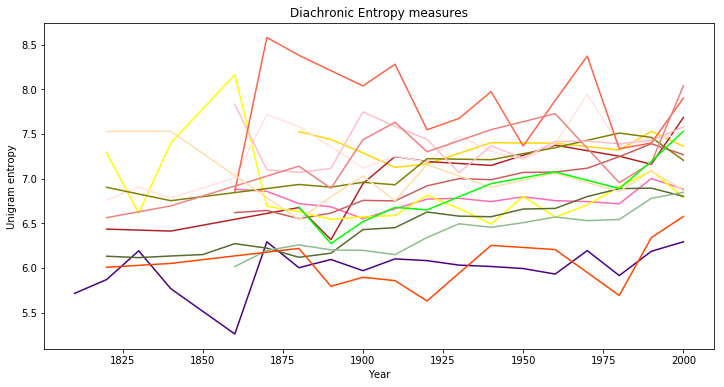

In [233]:
plt.figure(figsize=(12, 6))
genres = set(df['genre'])
genre_colors = ['blue', 'red', 'green', 'purple']

for i, genre_pair in enumerate(pairs):
    print("Genre pair:\t{}; {}".format(genre_pair, pair_colors[i]))
    curr_df = df_ce[df_ce['pair'] == genre_pair] \
        .sort_values(by=['decade'])
    plt.plot(curr_df['decade'], curr_df['ce'], color=pair_colors[i])
plt.title("Diachronic Entropy measures")
plt.ylabel("Unigram entropy")
plt.xlabel("Year")

# Outputs datas to .csv for R

In [234]:
df.to_csv("entropies.csv")
df_ce.to_csv("ces.csv")